In [7]:
# Load dependencies 
from transformers import AutoProcessor, AutoModelForImageTextToText
from transformers.image_utils import load_image
from PIL import Image

In [8]:
# Load model and processor
model_id = "LiquidAI/LFM2-VL-450M"
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="bfloat16",
    trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [9]:
# ===== LOAD TEST IMAGE =====
image_path = "./detected/003843_detections.jpg" 
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert("RGB")

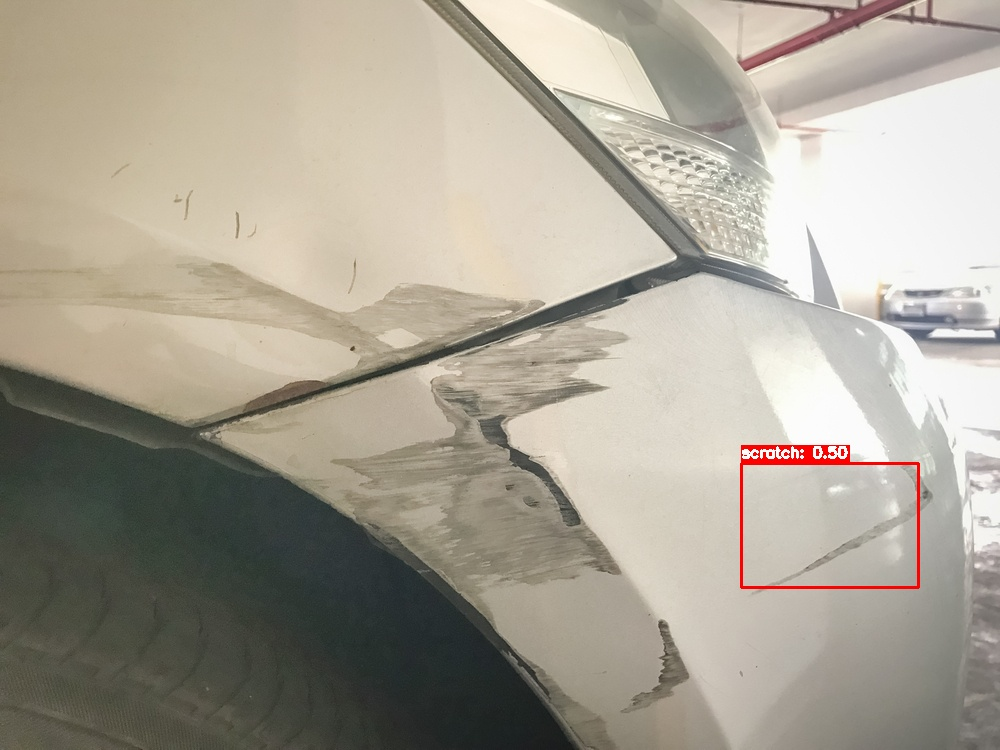

In [10]:
image

#### Step 1 Prompt Engineering - Basic 

In [11]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """Describe the image"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
The image shows a close-up view of a car's bumper and hood, focusing on a scratch. The bumper appears to be white with a black rubber mat underneath. The hood is white with a black stripe running down the center. The scratch is prominently displayed in the center of the image, with a


### Second Prompt Engineering: Improve the token length 
- Let's increase the amount of token generated

In [12]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """Describe the image"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 2)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
The image shows a close-up view of a car's bumper and hood, focusing on a scratch. The bumper appears to be white with a black rubber mat underneath. The hood is white with a black stripe running down the center. The scratch is prominently displayed in the center of the image, with a red box highlighting it. The background is blurry, but you can see a white car and a red pipe on the ceiling. The overall scene suggests this is likely a car shop or garage setting.


### Third Prompt Engineering: Improve the prompt - Extending the role of the VLM beyond image description 

In [13]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. Review the image and verify whether the car damages shown are consistent with the 
                following object detection results."""
                
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 2)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
The image shows a car with visible scratches on its surface. The scratches appear to be consistent with the object detection results provided, which indicate a "scratch: 0.50" in the bounding box. This score suggests that the scratches are relatively small and evenly distributed across the car's surface.

To verify this, we can compare the image with the object detection results:

1. **Object Detection Results**: The results show a "scratch: 0.50" with a bounding box centered around the area of the scratches.
2. **Comparison**: The scratches in the image


### Third Prompt Engineering: Obtaining structured output from VLM

In [14]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. 
Review the image and verify whether the car damages shown are consistent with the following object detection results. 

Return the result strictly as JSON in the format below (no extra text, only JSON)"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 3)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
```json
{
  "damage_verification": "true",
  "object_detection_results": [
    {
      "object": "scratches",
      "count": 1,
      "confidence": 0.30
    }
  ]
}
```


### Fourth Prompt Engineering: Formatting the structured output

In [15]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. 
            Review the image and verify whether the car damages shown are consistent with the following object detection results. 
            Return the result strictly as JSON in the format below (no extra text, only JSON):
            
            {   "short description of damages": "<>",
                "damage_types": "<e.g dent,scratch, crack, glass_shatter, lamp_broken, tire_flat>",
                "location_of_damages": "<>",
                "recommended_repair_work": "<>",
                "severity_of_damage": "<e.g., minor, medium, major>"
            }"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 3)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
```json
{
  "short description of damages": "The image shows a scratched area on the car's surface, with a red box highlighting the scratch area. The damage appears to be consistent with the object detection results provided.",
  "damage_types": "The damage is consistent with scratch damage, as indicated by the red box highlighting the scratch area.",
  "location_of_damages": "The scratch is located on the car's surface, which is consistent with the object detection results.",
  "recommended_repair_work": "No specific repair work is recommended for this scratch damage.",
  "severity_of_damage": "The damage is not severe, as it is a minor scratch."
}
```


### Second Example

In [16]:
from detector import detect_objects, load_image

In [17]:
output = detect_objects("./images/000035.jpg")
print("Result saved at:", output)

Saved annotated image to ./detected/000035_detections.jpg
Result saved at: ./detected/000035_detections.jpg


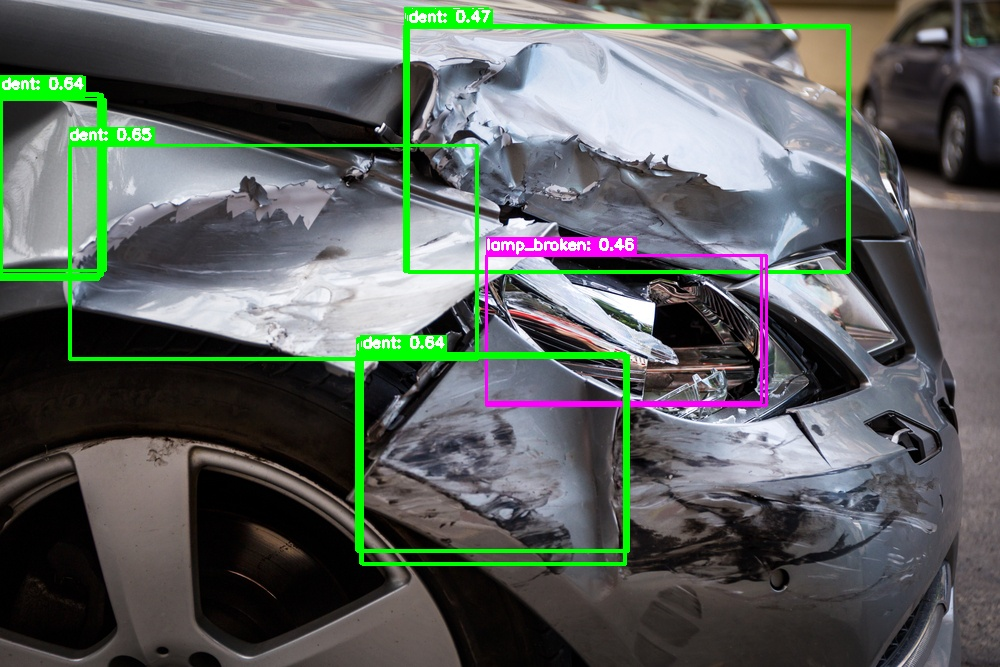

In [18]:
image = load_image(output)
image

In [19]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. 
            Review the image and verify whether the car damages shown are consistent with the following object detection results. 
            Return the result strictly as JSON in the format below (no extra text, only JSON):
            
            {   "short description of damages": "<>",
                "damage_types": "<e.g dent,scratch, crack, glass_shatter, lamp_broken, tire_flat>",
                "location_of_damages": "<>",
                "recommended_repair_work": "<>",
                "severity_of_damage": "<e.g., minor, medium, major>"
            }"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 3)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
```json
{
  "short description of damages": "The car has sustained significant damage to the front end, including a large dent and a cracked windshield. The front bumper is also severely damaged, with visible scratches and a broken glass piece.",
  "damage_types": "Dent, Crack, Glass Shatter, Lamp Broken",
  "location_of_damages": "Front bumper and windshield",
  "recommended_repair_work": "Damage to front bumper and windshield",
  "severity_of_damage": "Major"
}
```


### Third Example

In [20]:
output = detect_objects("./images/000024.jpg")
print("Result saved at:", output)

Saved annotated image to ./detected/000024_detections.jpg
Result saved at: ./detected/000024_detections.jpg


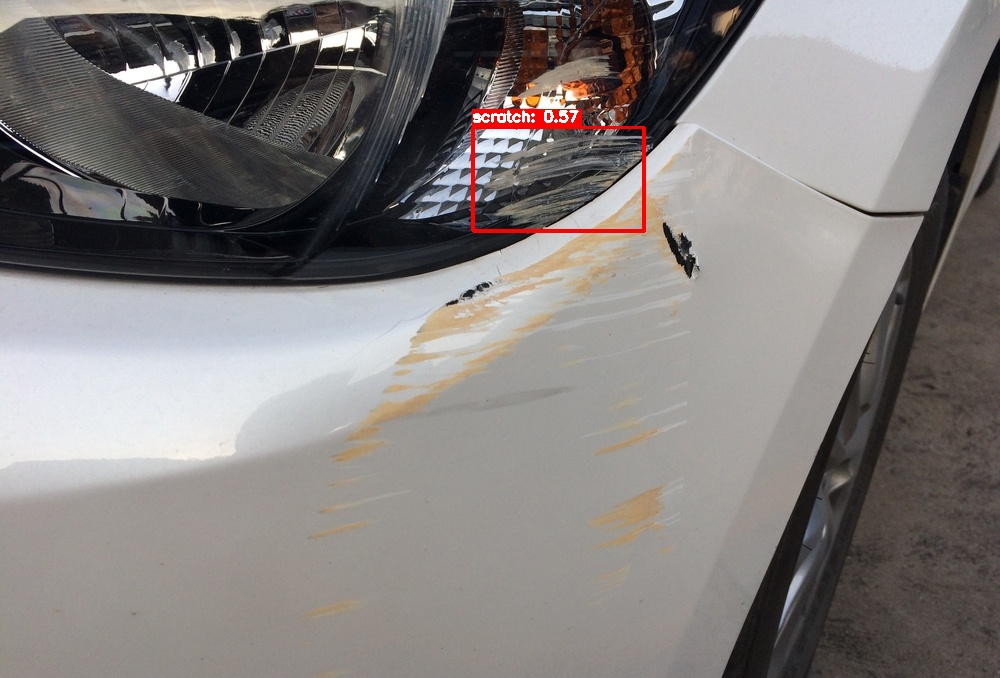

In [21]:
image = load_image(output)
image

In [22]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. 
            Review the image and verify whether the car damages shown are consistent with the following object detection results. 
            Return the result strictly as JSON in the format below (no extra text, only JSON):
            
            {   "short description of damages": "<>",
                "damage_types": "<e.g dent,scratch, crack, glass_shatter, lamp_broken, tire_flat>",
                "location_of_damages": "<>",
                "recommended_repair_work": "<>",
                "severity_of_damage": "<e.g., minor, medium, major>"
            }"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 3)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)


--- Model Response ---
```json
{
  "short description of damages": "The car has a scratch on the front bumper and a dent on the left side of the headlight.",
  "damage_types": "Scratch and dent",
  "location_of_damages": "Front bumper and left side of the headlight",
  "recommended_repair_work": "Scratches and dents are visible on the car's front bumper and left side of the headlight.",
  "severity_of_damage": "Moderate"
}
```


### Fourth Example

In [ ]:
output = detect_objects("./images/000575.jpg")
print("Result saved at:", output)

In [ ]:
image = load_image(output)
image

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. 
            Review the image and verify whether the car damages shown are consistent with the following object detection results. 
            Return the result strictly as JSON in the format below (no extra text, only JSON):
            
            {   "short description of damages": "<>",
                "damage_types": "<e.g dent,scratch, crack, glass_shatter, lamp_broken, tire_flat>",
                "location_of_damages": "<>",
                "recommended_repair_work": "<>",
                "severity_of_damage": "<e.g., minor, medium, major>"
            }"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 3)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)

### Fifth Example

In [ ]:
output = detect_objects("./images/003966.jpg")
print("Result saved at:", output)

In [ ]:
image = load_image(output)
image

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert automobile inspector. 
            Review the image and verify whether the car damages shown are consistent with the following object detection results. 
            Return the result strictly as JSON in the format below (no extra text, only JSON):
            
            {   "short description of damages": "<>",
                "damage_types": "<e.g dent,scratch, crack, glass_shatter, lamp_broken, tire_flat>",
                "location_of_damages": "<>",
                "recommended_repair_work": "<>",
                "severity_of_damage": "<e.g., minor, medium, major>"
            }"""
            },
        ],
    },
]

# Generate Answer
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)


outputs = model.generate(**inputs, max_new_tokens=64 * 3)
decoded = processor.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)